# Sprint 深層学習スクラッチ ディープニューラルネットワーク
* 前回作成した3層のニューラルネットワークを任意の層数に拡張しやすいものに書き換える
* その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにする
* 今後各種フレームワークを利用していくにあたり、内部の動きが想像できることを目指す
* 名前は新しくScratchDeepNeuralNetrowkClassifierクラスとする
* 万能近似定理より，中間層のノード数を増やすほど表現力は上がり，任意の関数に近づく（ただし，学習がうまくいくことを保証しているわけではない）

In [47]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import tensorflow as tf
import time
import matplotlib.pyplot as plt

In [48]:
# MNISTデータのダウンロード
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# 平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
# 型の変換
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# trainデータをtrainとvalに分ける
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print('X_train_shape',X_train.shape)
print('X_val_shape',X_val.shape)
print('y_train_shape',y_train.shape)
print('y_test_shape',y_test.shape)

X_train_shape (48000, 784)
X_val_shape (12000, 784)
y_train_shape (48000,)
y_test_shape (10000,)


In [49]:
# 正解データをOne-Hot表現に
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])
print('y_train_shape',y_train.shape) # (60000,)
print('y_train_one_hot_shape',y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

y_train_shape (48000,)
y_train_one_hot_shape (48000, 10)
float64


# ミニバッチ

In [50]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

# 【問題1】全結合層のクラス化
* コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意する
* 重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になる
* インスタンスも引数として渡すことができる
* そのため，初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われる．
* 渡すインスタンスを変えれば、初期化方法が変えられる
* 引数として自身のインスタンスselfを渡すこともできる．
* これを利用してself = self.optimizer.update(self)という風に層の重みの更新が可能
* 更新に必要な値は複数あるが，**全て全結合層が持つインスタンス変数にすることができる**

In [51]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス（ガウス分布とか）
    optimizer : 最適化手法のインスタンス（確率的勾配降下とか）
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1,n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.optimizer = optimizer
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力（最初はX,以降はZ）
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.Z = X
        A = np.dot(self.Z,self.W) + self.B
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dZ = dA@self.W.T
        self.dW = self.Z.T@dA
        self.dB = np.sum(dA,axis=0)
        
        self.optimizer.update(self)
        return dZ

# 【問題2】初期化方法のクラス化
* 全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにする
* 標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになる

In [52]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 次の形のndarray shape(n_nodes1,n_nodes2)
        """
        self.sigma = 0.01
        W = self.sigma * np.random.randn(n_nodes1,n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 次の形のaray shape(n_nodes2)
        """
        B = self.sigma * np.random.randn(n_nodes2)
        return B

# 【問題3】最適化手法のクラス化
* 最適化手法は全結合層にインスタンスとして渡す。
* バックワードのときにself = self.optimizer.update(self)のように更新できるようにする。
* これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成する

In [53]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    
    
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.W = layer.W - self.lr*layer.dW
        layer.B = layer.B - self.lr*layer.dB
    
        #return layer

# 【問題4】活性化関数のクラス化

## ハイパボリックタンジェント

In [54]:
class Tanh:
    """
    ハイパボリックタンジェント関数（活性化関数）
    """
    
    def forward(self,X):
        """
        Parameters
        ----------
        X : 次の形のndarray shape(batch_size,n_nodes)

        Returns
        -------
        Z : 次の形のndarray  shape (batch_size,n_nodes) 
        """
        self.A = X
        Z = np.tanh(self.A)
        return Z


    def backward(self,dZ):
        """
        Parameters
        ----------
        dZ : 次の形のndarray shape(batch_size,n_nodes)

        Returns
        -------
        dA : 次の形のndarray  shape (batch_size,n_nodes) 
        """
        dA = dZ * (1 - np.tanh(self.A)**2)
        return dA

## シグモイド

In [55]:
class Sigmoid:
    """
    シグモイド関数レイヤ（活性化関数）
    """
    
    def _sigmoid(self,A):
        """
        ０～１の間の値を返すシグモイド関数
        """
        return 1/(1 + np.exp(-A))
    
    
    def forward(self,X):
        """ 
        Parameters
        ----------
        X : 次の形のndarray shape(batch_size,n_nodes)

        Returns
        -------
        Z : 次の形のndarray  shape (batch_size,n_nodes) 
        """
        self.A = X
        Z = self._sigmoid(self.A)
        return Z


    def backward(self,dZ):
        """
        Parameters
        ----------
        dZ : 次の形のndarray shape(batch_size,n_nodes)

        Returns
        -------
        dA : 次の形のndarray  shape (batch_size,n_nodes) 
        """
        dA = dZ * (1 - self._sigmoid(self.A))*self._sigmoid(self.A)
        return dA

## ソフトマックス
ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化される

In [56]:
class Softmax:
    """
    ソフトマックス関数
    
    """
    
    def forward(self,A3):
        exp_A = np.exp(A3)
        sum_A = np.sum(exp_A,axis=1).reshape(-1,1)
        Z3 = exp_A/sum_A
        return Z3
    
    def backward(self,Z3,Y):
        batch_n = Y.shape[0]
        # A3の勾配
        dA3 = Z3 - Y
        #print('soft_max_dA3',dA3.shape)
        
        # 交差エントロピー誤差
        loss = -np.sum(Y*np.log(Z3+1e-7)) / batch_n
             
        return dA3,loss

# 【問題5】ReLUクラスの作成

In [57]:
class ReLU:
    def forward(self,A):
        self.A = A
        Z = np.maximum(0,A)
        return Z 
    
    def backward(self,dZ):
        #np.signでAを-1，0，1に変換
        dA = dZ * (np.maximum(0,np.sign(self.A)))
        return dA

# 【問題6】重みの初期値 
* ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきた
* シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われる（勾配消失問題に対応するため）
* XavierInitializerクラスと、HeInitializerクラスを作成
## Xavierの初期値
初期値における標準偏差σ$$\sigma=\frac{1}{\sqrt{n}}$$        　        
n : 前の層のノード数                         
http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

In [58]:
class XavierInitializer:
    """
    シグモイドやハイパボリックタンジェントの時の重みの初期値

    Parameters
    ----------
    A : 次の形のndarray shape(batch_size,n_nodes)

    Returns
    -------
    次の形のndarray  shape (batch_size,n_nodes) 
    """
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 
        """
        self.sigma = 1/np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1,n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 
        """
        B = self.sigma * np.random.randn(n_nodes2)
        return B

## Heの初期値
Heの初期値における標準偏差σ$$\sigma=\sqrt{\frac{2}{n}}$$      
n : 前のノード数                                      
https://arxiv.org/pdf/1502.01852.pdf

In [59]:
class HeInitializer:
    """
    ReLUの時の重みの初期値
    """
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 
        """
        self.sigma = np.sqrt(2/n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1,n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 
        """
        B = self.sigma * np.random.randn(n_nodes2)
        return B

# 【問題7】最適化手法
* 学習率は学習過程で変化させていく方法が一般的
* 基本的な手法である **AdaGrad** のクラスを作成
* AdaGradは，更新された分だけその重みに対する学習率を徐々に下げていき，イテレーションごとの勾配の二乗和Hを保存しておき、その分だけ学習率を小さくする
* つまり，学習率は重み一つひとつに対して異なることになる
$$H'_i=H_i+E(\frac{\partial L}{\partial W_i})\times E(\frac{\partial L}{\partial W_i})\\
W'_i=W_i-α\frac{1}{\sqrt{H'_i}}E(\frac{\partial L}{\partial W_i})$$

In [60]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        hW = 1
        hB = 1
        hW = hW + (layer.W**2)
        hB = hB + (layer.B**2)
        layer.W = layer.W - self.lr*(1/np.sqrt(hW))*layer.dW
        layer.B = layer.B - self.lr*(1/np.sqrt(hB))*layer.dB
    
        return layer

# 問題8】クラスの完成

In [61]:
class ScratchDeepNeuralNetrowkClassifier:
    def __init__(self, lr, epochs, batch_size, n_nodes1, n_nodes2, initializer, optimizer, activation, verbose):
        self.lr = lr
        self.epochs = epochs
        self.batch_n = batch_size
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer()     #重み・バイアスの初期化方法
        self.optimizer = optimizer(self.lr)  #最適化手法のインスタンス
        self.activation = activation         # 活性化関数
        self.verbose = verbose               #学習過程
        
    # yにはエンコードしてないものを入れる    
    def fit(self, X, y, X_val=None, y_val=None):
        # lossを入れる箱
        self.loss = []
        self.val_loss = []
        self.n_features = X.shape[1]
        self.n_output = np.unique(y).size
        
        # 正解データをOne-Hot表現に
        from sklearn.preprocessing import OneHotEncoder
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_one_hot = enc.fit_transform(y[:, np.newaxis])
       
        # １層目のインスタンス
        self.FC1 = FC(self.n_features, self.n_nodes1, self.initializer, self.optimizer)
        self.activation1 = self.activation()
        # ２層目のインスタンス
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, self.initializer, self.optimizer)
        self.activation2 = self.activation()
        # ３層目のインスタンス
        self.FC3 = FC(self.n_nodes2, self.n_output, self.initializer, self.optimizer)
        self.activation3 = Softmax()
 
        # epochs開始
        for e in range(self.epochs):
            # ミニバッチの取得
            get_mini_batch = GetMiniBatch(X, y_one_hot, batch_size=self.batch_n)
            # ミニバッチ開始
            for mini_X_train, mini_y_train in get_mini_batch:
                # フォワードプロパゲーション
                A1 = self.FC1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                #交差エントロピー
                dA3,loss = self.activation3.backward(Z3, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                self.loss.append(loss)
                # バックフォワード
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
            
            if X_val is not None:
                y_one_hot_val = enc.fit_transform(y_val[:, np.newaxis])
                get_mini_batch_v = GetMiniBatch(X_val, y_one_hot_val, batch_size=self.batch_n)
                for mini_X_train_val, mini_y_train_val in get_mini_batch_v:
                    # フォワードプロパゲーション
                    A1_val = self.FC1.forward(mini_X_train_val)
                    #print('A1',A1.shape)
                    Z1_val = self.activation1.forward(A1_val)
                    #print('Z1',Z1.shape)
                    A2_val = self.FC2.forward(Z1_val)
                    #print('A2',A2.shape)
                    Z2_val = self.activation2.forward(A2_val)
                    #print('Z2',Z2.shape)
                    A3_val = self.FC3.forward(Z2_val)
                    #print('A3',A3.shape)
                    Z3_val = self.activation3.forward(A3_val)
                    #print('Z3',Z3.shape)
                    dA3_val,val_loss = self.activation3.backward(Z3_val,mini_y_train_val)
                    self.val_loss.append(val_loss)
            else:
                pass              
                
            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose is True:
                print('Train Data Loss epoch {0} : {1}'.format(e,loss))
                print('Validation Loss epoch {0} : {1}'.format(e,val_loss))
            else:
                pass


    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
        pred : 次の形のndarray, shape (n_samples, 1)  推定結果
        """
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        pred = np.argmax(Z3,axis=1)
        return pred

In [62]:
# initializer=初期化(Simple,He,Xa)，optimizer=最適化手法(SGD or AdAdaGrad)，activation=活性化関数(Sigmoid,Tanh,ReLU)
DNNC1 = ScratchDeepNeuralNetrowkClassifier(lr=0.001, epochs=10, batch_size=20, n_nodes1=400, n_nodes2=200,
                                          initializer=XavierInitializer, optimizer=SGD, activation=Tanh, verbose=True)

In [63]:
DNNC1.fit(X_train,y_train,X_val,y_val)

Train Data Loss epoch 0 : 0.39040829796285903
Validation Loss epoch 0 : 0.23907602165820235
Train Data Loss epoch 1 : 0.2959907737463845
Validation Loss epoch 1 : 0.170492079072544
Train Data Loss epoch 2 : 0.23286712687082947
Validation Loss epoch 2 : 0.14064656515462456
Train Data Loss epoch 3 : 0.18913190564375118
Validation Loss epoch 3 : 0.1261163828462685
Train Data Loss epoch 4 : 0.1608937095575619
Validation Loss epoch 4 : 0.11620443748989402
Train Data Loss epoch 5 : 0.14124114106262803
Validation Loss epoch 5 : 0.11070189915799247
Train Data Loss epoch 6 : 0.1261072253364053
Validation Loss epoch 6 : 0.10885372071771596
Train Data Loss epoch 7 : 0.11341668124220468
Validation Loss epoch 7 : 0.10910517211347966
Train Data Loss epoch 8 : 0.10216698923832575
Validation Loss epoch 8 : 0.11006668075350481
Train Data Loss epoch 9 : 0.0917684333641858
Validation Loss epoch 9 : 0.11081542034443045


In [64]:
y_pred1 = DNNC1.predict(X_test)
print('accuracy_score',accuracy_score(y_test, y_pred1))
print('y_predの中身：',np.unique(y_pred1,return_counts=True))

accuracy_score 0.9686
y_predの中身： (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64), array([1001, 1145, 1004, 1028,  977,  873,  956, 1021,  976, 1019],
      dtype=int64))


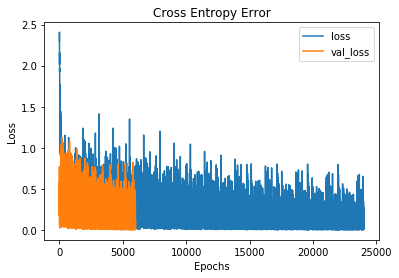

In [65]:
# 可視化
plt.plot(DNNC1.loss,label='loss')
plt.plot(DNNC1.val_loss,label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Cross Entropy Error')
plt.legend()
plt.show()

In [66]:
# initializer=初期化(Simple,He,Xa)，optimizer=最適化手法(SGD or AdAdaGrad)，activation=活性化関数(Sigmoid,Tanh,ReLU)
DNNC2 = ScratchDeepNeuralNetrowkClassifier(lr=0.001, epochs=10, batch_size=20, n_nodes1=400, n_nodes2=200,
                                          initializer=XavierInitializer, optimizer=AdaGrad, activation=Sigmoid, verbose=True)

In [67]:
DNNC2.fit(X_train,y_train,X_val,y_val)

Train Data Loss epoch 0 : 1.1426707849800564
Validation Loss epoch 0 : 1.2111558532113762
Train Data Loss epoch 1 : 0.6695909578866357
Validation Loss epoch 1 : 0.4847673043583562
Train Data Loss epoch 2 : 0.5361914029356589
Validation Loss epoch 2 : 0.32272878730673904
Train Data Loss epoch 3 : 0.45658769620387546
Validation Loss epoch 3 : 0.2618121780251276
Train Data Loss epoch 4 : 0.41010347399065267
Validation Loss epoch 4 : 0.23042365605801313
Train Data Loss epoch 5 : 0.38126258968394044
Validation Loss epoch 5 : 0.20953382701639772
Train Data Loss epoch 6 : 0.36153842657759616
Validation Loss epoch 6 : 0.19428220148365669
Train Data Loss epoch 7 : 0.34644796088646956
Validation Loss epoch 7 : 0.18324730393338545
Train Data Loss epoch 8 : 0.3337228961287778
Validation Loss epoch 8 : 0.1756930737901218
Train Data Loss epoch 9 : 0.32229760885571945
Validation Loss epoch 9 : 0.17093177267518259


In [68]:
y_pred2 = DNNC2.predict(X_test)
print('accuracy_score',accuracy_score(y_test, y_pred2))
print('y_predの中身：',np.unique(y_pred2,return_counts=True))

accuracy_score 0.9181
y_predの中身： (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64), array([1032, 1142,  996,  992, 1004,  846,  965, 1030,  947, 1046],
      dtype=int64))


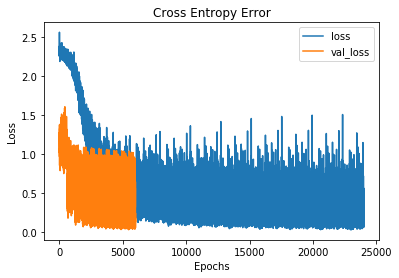

In [69]:
# 可視化
plt.plot(DNNC2.loss,label='loss')
plt.plot(DNNC2.val_loss,label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Cross Entropy Error')
plt.legend()
plt.show()

In [70]:
# initializer=初期化(Simple,He,Xa)，optimizer=最適化手法(SGD or AdAdaGrad)，activation=活性化関数(Sigmoid,Tanh,ReLU)
DNNC3 = ScratchDeepNeuralNetrowkClassifier(lr=0.001, epochs=10, batch_size=20, n_nodes1=400, n_nodes2=200,
                                          initializer=HeInitializer, optimizer=AdaGrad, activation=ReLU, verbose=True)

In [71]:
DNNC3.fit(X_train,y_train,X_val,y_val)

Train Data Loss epoch 0 : 0.2151307845974042
Validation Loss epoch 0 : 0.188357196462673
Train Data Loss epoch 1 : 0.13111285454737798
Validation Loss epoch 1 : 0.12066612024284784
Train Data Loss epoch 2 : 0.0927514970524083
Validation Loss epoch 2 : 0.10084446884490565
Train Data Loss epoch 3 : 0.06640664930552613
Validation Loss epoch 3 : 0.10274920701675574
Train Data Loss epoch 4 : 0.04765892153564598
Validation Loss epoch 4 : 0.11242224911003981
Train Data Loss epoch 5 : 0.03616910945855972
Validation Loss epoch 5 : 0.1213714920130687
Train Data Loss epoch 6 : 0.02962376807400826
Validation Loss epoch 6 : 0.14081894839410328
Train Data Loss epoch 7 : 0.02491618574795102
Validation Loss epoch 7 : 0.15673457003052435
Train Data Loss epoch 8 : 0.021850266703428423
Validation Loss epoch 8 : 0.19053634757497295
Train Data Loss epoch 9 : 0.019551901604465287
Validation Loss epoch 9 : 0.22158247242062984


In [72]:
y_pred3 = DNNC3.predict(X_test)
print('accuracy_score',accuracy_score(y_test, y_pred3))
print('y_predの中身：',np.unique(y_pred3,return_counts=True))

accuracy_score 0.9749
y_predの中身： (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64), array([ 987, 1145, 1002, 1036,  982,  870,  956, 1024,  971, 1027],
      dtype=int64))


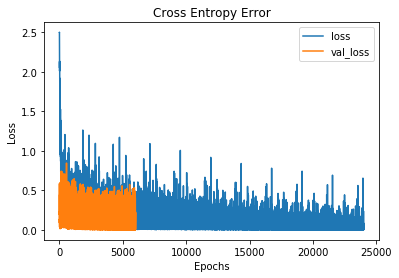

In [73]:
# 可視化
plt.plot(DNNC3.loss,label='loss')
plt.plot(DNNC3.val_loss,label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Cross Entropy Error')
plt.legend()
plt.show()

# Lossの計算位置を変えてみました．

In [74]:
class ScratchDeepNeuralNetrowkClassifier2:
    def __init__(self, lr, epochs, batch_size, n_nodes1, n_nodes2, initializer, optimizer, activation, verbose):
        self.lr = lr
        self.epochs = epochs
        self.batch_n = batch_size
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer()     #重み・バイアスの初期化方法
        self.optimizer = optimizer(self.lr)  #最適化手法のインスタンス
        self.activation = activation         # 活性化関数
        self.verbose = verbose               #学習過程
        
    # yにはエンコードしてないものを入れる    
    def fit(self, X, y, X_val=None, y_val=None):
        # lossを入れる箱
        self.loss = []
        self.val_loss = []
        self.n_features = X.shape[1]
        self.n_output = np.unique(y).size
        
        # 正解データをOne-Hot表現に
        from sklearn.preprocessing import OneHotEncoder
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_one_hot = enc.fit_transform(y[:, np.newaxis])
       
        # １層目のインスタンス
        self.FC1 = FC(self.n_features, self.n_nodes1, self.initializer, self.optimizer)
        self.activation1 = self.activation()
        # ２層目のインスタンス
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, self.initializer, self.optimizer)
        self.activation2 = self.activation()
        # ３層目のインスタンス
        self.FC3 = FC(self.n_nodes2, self.n_output, self.initializer, self.optimizer)
        self.activation3 = Softmax()
 
        # epochs開始
        for e in range(self.epochs):
            #lossの初期化
            loss = 0
            # ミニバッチの取得
            get_mini_batch = GetMiniBatch(X, y_one_hot, batch_size=self.batch_n)
            # ミニバッチ開始
            for mini_X_train, mini_y_train in get_mini_batch:
                # フォワードプロパゲーション
                A1 = self.FC1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                #softmax & 交差エントロピー
                dA3,loss = self.activation3.backward(Z3, mini_y_train)
                loss += loss
                
                # バックプロパゲーション
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
            
            #検証用データがある場合
            if X_val is not None:
                y_one_hot_val = enc.fit_transform(y_val[:, np.newaxis])
                A1_val = self.FC1.forward(X_val)
                Z1_val = self.activation1.forward(A1_val)
                A2_val = self.FC2.forward(Z1_val)
                Z2_val = self.activation2.forward(A2_val)
                A3_val = self.FC3.forward(Z2_val)
                Z3_val = self.activation3.forward(A3_val)
                dA3_val,val_loss = self.activation3.backward(Z3_val,y_one_hot_val)
            else:
                pass
            
            #lossを記録
            self.loss.append(loss/self.batch_n)
            self.val_loss.append(val_loss)
                
            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose is True:
                print('Train Data Loss epoch {0} : {1}'.format(e,self.loss[-1]))
                print('Validation Loss epoch {0} : {1}'.format(e,self.val_loss[-1]))
            else:
                pass


    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
        pred : 次の形のndarray, shape (n_samples, 1)  推定結果
        """
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        pred = np.argmax(Z3,axis=1)
        return pred

In [75]:
# initializer=初期化(Simple,He,Xa)，optimizer=最適化手法(SGD or AdaGrad)，activation=活性化関数(Sigmoid,Tanh,ReLU)
DNNC = ScratchDeepNeuralNetrowkClassifier2(lr=0.001, epochs=10, batch_size=20, n_nodes1=400, n_nodes2=200,
                                          initializer=XavierInitializer, optimizer=SGD, activation=Tanh, verbose=True)

In [76]:
DNNC.fit(X_train,y_train,X_val,y_val)

Train Data Loss epoch 0 : 0.03808021673277279
Validation Loss epoch 0 : 0.2962751661688784
Train Data Loss epoch 1 : 0.028586627708018852
Validation Loss epoch 1 : 0.24727694464759667
Train Data Loss epoch 2 : 0.02277014541910813
Validation Loss epoch 2 : 0.21035800606512609
Train Data Loss epoch 3 : 0.018961110875677676
Validation Loss epoch 3 : 0.18275822675816172
Train Data Loss epoch 4 : 0.016195633989309052
Validation Loss epoch 4 : 0.16241150328143625
Train Data Loss epoch 5 : 0.013967705151971224
Validation Loss epoch 5 : 0.1468451811615928
Train Data Loss epoch 6 : 0.012132812790169981
Validation Loss epoch 6 : 0.13460920900055723
Train Data Loss epoch 7 : 0.01062723540783586
Validation Loss epoch 7 : 0.12483572918431256
Train Data Loss epoch 8 : 0.00937516734740888
Validation Loss epoch 8 : 0.11692465473682724
Train Data Loss epoch 9 : 0.008307008585355942
Validation Loss epoch 9 : 0.11043382053902086


In [77]:
y_pred = DNNC.predict(X_test)
print('accuracy_score',accuracy_score(y_test, y_pred))
print('y_predの中身：',np.unique(y_pred,return_counts=True))

accuracy_score 0.9682
y_predの中身： (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64), array([1004, 1145, 1009, 1014,  984,  869,  957, 1019,  974, 1025],
      dtype=int64))


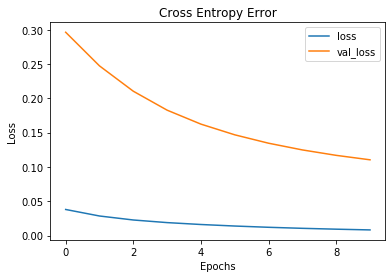

In [78]:
# 可視化
plt.plot(DNNC.loss,label='loss')
plt.plot(DNNC.val_loss,label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Cross Entropy Error')
plt.legend()
plt.show()